Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [81]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [82]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
spk427R = get_for_learn_clean_df_spk427R(for_ml)
spk400 = get_for_learn_clean_df_spk400(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
for_ml = for_ml[for_ml['wellName'] != 'spk427R']
for_ml = pd.concat([for_ml, spk400, spk427R])
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD       Facies         AGR         ASP          BK  \
count   310.000000   310.000000  310.000000  310.000000  310.000000   
mean   2586.900000 -2415.990323    0.443719    0.091886    9.137045   
std      17.926703  4290.816865    0.260089    0.094558    7.720558   
min    2556.000000 -9999.000000    0.000000    0.000000    5.345500   
25%    2571.450000     0.000000    0.214541    0.011352    7.181000   
50%    2586.900000     5.000000    0.417163    0.052764    7.973250   
75%    2602.350000     5.000000    0.643623    0.178180    8.979625   
max    2617.800000     8.000000    1.000000    0.317823  129.264500   

               GR         LIT        NKTB          SP  
count  310.000000  310.000000  310.000000  310.000000  
mean    10.891935    2.051613    3.933336  113.830968  
std      3.222438    1.422398    0.650787    4.948310  
min      5.300000    1.000000    3.033252  103.900000  
25%      9.000000    1.000000    3.550536  110.600000  
50%     10.900000    1.000000    3.795809  113.200000  
75%     12.600000    4.000000    4.129428  118.400000  
max     37.100000    5.000000    8.385099  123.600000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



BK        Facies            GR           LIT            MD  \
count  65951.000000  69839.000000  69839.000000  69839.000000  69839.000000   
mean   -1579.525331  -9517.122396   -277.581893  -7693.602557   2297.936202   
std     3674.660162   2142.106428   1675.647925   4212.096414    265.521343   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.383000  -9999.000000      7.949000  -9999.000000   2078.400000   
50%        6.770000  -9999.000000     10.080000  -9999.000000   2292.200000   
75%        9.380000  -9999.000000     12.600000  -9999.000000   2497.600000   
max    22739.520000     12.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  
count  69839.000000  69839.000000  
mean    -275.478164      2.011366  
std     1647.951269   1028.578321  
min    -9999.000000  -9999.000000  
25%        3.250043     82.895565  
50%        3.750000    106.186100  
75%        4.200779    123.124450  
max       15.351170    578.255500

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
3    4.280000   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
4    4.260000   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
..        ...     ...    ...    ...   ...     ...       ...     ...      ...
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R

[69839 rows x 9 columns]

['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk402' 'spk403' 'spk405R'
 'spk406R' 'spk409R' 'spk420R' 'spk424R' 'spk426R' 'spk428R' 'spk429L'
 'spk432R' 'spk967' 'spk400_shift' 'spk427R']


In [3]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        return undefined_value
    if math.isnan(x):
        return undefined_value
    if math.isinf(x):
        return undefined_value
    return x

def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1
        #min_ = well_copy[name_feature_extraction].min()
        #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
            #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x - abs(min_))
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=10,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        
#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
#                         timeperiod=10,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower
        del well_copy[name_feature_extraction]
        well_copy = well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
well_with_features = get_well_with_features_df_intervals(well_with_features, ['GR'], [0.2])

SP_0
SP_1
SP_2


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0


In [37]:
def get_well_with_distance_features(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy

def get_well_with_features_df(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        
        well_copy = get_well_with_distance_features(well_copy)

        wells_return.append(well_copy)
    return wells_return

def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

 

def get_well_with_features_df1(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT', 'LAYER']
    wells_return = []
    import math
    for well in wells:
        well_copy = well.copy()  
        from talib import MA_Type


        well_copy['SP'] = well_copy['SP'].apply(change_null)
        well_copy['GR'] = well_copy['GR'].apply(change_null)
        well_copy['BK'] = well_copy['BK'].apply(change_null)
        well_copy['NKTB'] = well_copy['NKTB'].apply(change_null)
        
#         well_copy = get_well_with_distance_features(well_copy)
#         well_copy['SP_SMA'] = talib.TRIX(well_copy['SP'], timeperiod=10) 
#         well_copy['GR_SMA_20'] = talib.TRIX(well_copy['GR'], timeperiod=20)
        well_copy['GR_SMA_10'] = talib.TRIX(well_copy['GR'], timeperiod=15)
        #print(well_copy['SP'])
        #print(well_copy['SP'][::-1])
        #reversed_arr = arr[::-1]


#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                                 timeperiod=28,
#                                 nbdevup=2,
#                                 nbdevdn=2,
#                                 matype=talib.MA_Type.EMA)

#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower

#         upper, middle, lower = talib.BBANDS(well_copy['NKTB'].apply(change_null),
#                                             timeperiod=16,
#                                             nbdevup=13,
#                                             nbdevdn=4,
#                                             matype=talib.MA_Type.EMA)
#         well_copy['NKTB_upper'] = upper
#         well_copy['NKTB_middle'] = middle
#         well_copy['NKTB_lower'] = lower


#         upper, middle, lower = talib.BBANDS(well_copy['BK'].apply(change_null), timeperiod=21)
#         well_copy['BK_upper'] = upper
#         well_copy['BK_middle'] = middle
#         well_copy['BK_lower'] = lower

#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null), timeperiod=24)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower


#         well_copy['NKTB_upper_shift'] = well_copy['NKTB_upper'].shift(-12)
#         well_copy['NKTB_middle_shift'] = well_copy['NKTB_middle'].shift(-12)
#         well_copy['NKTB_lower_shift'] = well_copy['NKTB_lower'].shift(-12)


#         #display(well_copy)
#         #display(well_copy.describe())
#         for feature_name in well_copy.columns:
#             if feature_name not in not_change_null:
#                 well_copy[feature_name] = well_copy[feature_name].apply(change_null)

            #display(well_copy)
            #del well_copy['SP']
        #well_copy['GR_TRANGE'] = talib.TRANGE(upper, middle, middle)
        
        
#         for name_feature in ['SP', 'GR']:
#             well_copy[name_feature + 'mom_25'] = talib.MOM(well_copy[name_feature], timeperiod=25)
#             well_copy[name_feature + 'sma'] = talib.SMA(well_copy[name_feature])
#             well_copy[name_feature + 'HT_DCPERIOD'] = talib.HT_DCPERIOD(well_copy[name_feature])
#             well_copy[name_feature + 'HT_TRENDMODE'] = talib.HT_TRENDMODE(well_copy[name_feature])
#             well_copy[name_feature + 'CMO_14'] = talib.CMO(well_copy[name_feature], timeperiod=14)
#             well_copy[name_feature + 'CMO_25'] = talib.CMO(well_copy[name_feature], timeperiod=25)
#             well_copy[name_feature + 'ROC_10'] = talib.ROC(well_copy[name_feature], timeperiod=10)
#             well_copy[name_feature + 'ROC_20'] = talib.ROC(well_copy[name_feature], timeperiod=20)
#             well_copy[name_feature + 'ROC_30'] = talib.ROC(well_copy[name_feature], timeperiod=30)
#             well_copy[name_feature + 'TRIX_30'] = talib.TRIX(well_copy[name_feature], timeperiod=30)
#             inphase, quadrature = talib.HT_PHASOR(well_copy[name_feature])
#             well_copy[name_feature + 'HT_PHASOR_inphase'] = inphase
#             well_copy[name_feature + 'HT_PHASOR_quadrature'] = quadrature
#             sine, leadsine = talib.HT_SINE(well_copy[name_feature])
#             well_copy[name_feature + 'HT_SINE_sine'] = sine
#             well_copy[name_feature + 'HT_SINE_leadsine'] = leadsine
#             well_copy[name_feature + 'APO_12_26'] = talib.APO(well_copy[name_feature], fastperiod=12, slowperiod=26, matype=0)

#             upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
#             well_copy[name_feature + 'upper_BBANDS_25'] = upper
#             well_copy[name_feature + 'middle_BBANDS_25'] = middle
#             well_copy[name_feature + 'lower_BBANDS_25'] = lower

#             upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
#             well_copy[name_feature + 'upper_BBANDS_10'] = upper
#             well_copy[name_feature + 'middle_BBANDS_10'] = middle
#             well_copy[name_feature + 'lower_BBANDS_10'] = lower

#             upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
#             well_copy[name_feature + 'upper_BBANDS_5'] = upper
#             well_copy[name_feature + 'middle_BBANDS_5'] = middle
#             well_copy[name_feature + 'lower_BBANDS_5'] = lower

#             well_copy[name_feature + 'KAMA_30'] = talib.KAMA(well_copy[name_feature], timeperiod=30)
#             well_copy[name_feature + 'KAMA_20'] = talib.KAMA(well_copy[name_feature], timeperiod=20)
#             well_copy[name_feature + 'DEMA_20'] = talib.DEMA(well_copy[name_feature], timeperiod=20)
#             well_copy[name_feature + 'EMA_20'] = talib.EMA(well_copy[name_feature], timeperiod=20)
#             well_copy[name_feature + 'EMA_5'] = talib.EMA(well_copy[name_feature], timeperiod=5)
#             well_copy[name_feature + 'EMA_45'] = talib.EMA(well_copy[name_feature], timeperiod=45)
            
        for feature_name in well_copy.columns:
            if feature_name not in not_change_null:
                well_copy[feature_name] = well_copy[feature_name].apply(change_null)
            
        wells_return.append(well_copy)
    return wells_return

well_with_features_ = get_well_with_features_df1(well_with_features)

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName  \
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521   
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521   
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521   
5    4.410000   -9999  12.64  -9999 -9999  2012.0  3.024832   97.77  spk1521   
6    4.500000   -9999  12.61  -9999 -9999  2012.2  3.055148   97.45  spk1521   
..        ...     ...    ...    ...   ...     ...       ...     ...      ...   
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R   
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R   
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R   
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R   
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R   

     interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
0                                  3                  97.57   
1                                  3                  97.57   
2                                  3                  97.57   
5                                  5                 100.31   
6                                  5                 100.31   
..                               ...                    ...   
305                               13                 113.20   
306                               13                 113.20   
307                                3                 110.90   
308                                3                 110.90   
309                                3                 110.90   

     min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
0                    97.02                               35   
1                    97.02                               35   
2                    97.02                               35   
5                    97.45                               35   
6                    97.45                               35   
..                     ...                              ...   
305                 109.90                                2   
306                 109.90                                3   
307                 110.60                                3   
308                 110.60                                3   
309                 110.60                                1   

     max_GRinterval_0.2_GR  min_GRinterval_0.2_GR    GR_SMA_10  
0                    14.75                  10.79 -9999.000000  
1                    14.75                  10.79 -9999.000000  
2                    14.75                  10.79 -9999.000000  
5                    14.75                  10.79 -9999.000000  
6                    14.75                  10.79 -9999.000000  
..                     ...                    ...          ...  
305                  12.70                  12.60     0.615789  
306                  13.70                  12.90     0.571693  
307                  13.70                  12.90     0.540863  
308                  13.70                  12.90     0.512629  
309                  13.50                  13.50     0.489474  

[69377 rows x 16 columns]

In [72]:
def get_well_with_7(all_well_df):
    wall_names_ = all_well_df[all_well_df['Facies'] == 7]['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def filter_middle_7(wells, period):
    results = []
    wells_copy = wells.copy()
    for well in wells_copy:
        well['shift_up'] = well["Facies"].shift(period)
        well['shift_dw'] = well["Facies"].shift(-period)
        well['is_middle'] = well['shift_up'] * well['shift_dw']
        well = well.fillna(0)
        display(well[well['is_middle'] == 49].describe())
        well = well[well['is_middle'] != 49]
        del well['shift_up']
        del well['shift_dw']
        del well['is_middle']
        results.append(well)
    return results
        
def well_with_7(wells):
    wells_copy = wells.copy()

    for well in wells_copy:
        #well = well[well["Facies"] == 7]
        #well = well[well["Facies"] < 13]
        display(well.describe())
        well_name = well['wellName'].unique()
        
        well.plot(x='MD', y=['Facies'], figsize=(15,8), grid=True)
        plt.xlabel('MD')
        plt.ylabel('Facies')
        plt.title(well_name + ' Facies')

        plt.title("Гистограмма Facies")
        #well['Facies'].hist(figsize=(15,8), x=well['MD'])
        plt.show()
        
    return wells

wells_with_7 = get_well_with_7(pd.concat(well_with_features))
wells_with_7_filered = filter_middle_7(wells_with_7, 8)

for_ml_preprocessing = pd.concat(wells_with_7_filered)
display(for_ml_preprocessing)

['spk1521' 'spk1527' 'spk400' 'spk424R' 'spk428R' 'spk429L' 'spk432R'
 'spk400_shift']


BK  Facies          GR         LIT          MD        NKTB  \
count  102.000000   102.0  102.000000  102.000000   102.00000  102.000000   
mean    11.776471     7.0    8.669314    4.176471  3038.70000    5.310757   
std      7.518042     0.0    0.967234    0.666181     5.91777    0.392955   
min      4.020000     7.0    6.740000    2.000000  3028.60000    4.295065   
25%      6.215000     7.0    7.915000    4.000000  3033.65000    5.098119   
50%     10.225000     7.0    8.675000    4.000000  3038.70000    5.276179   
75%     14.055000     7.0    9.387500    5.000000  3043.75000    5.521079   
max     45.320000     7.0   10.670000    5.000000  3048.80000    6.191994   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count  102.000000                       102.000000             102.000000   
mean   100.114314                        13.627451             103.844706   
std      3.418810                         9.043264               3.581940   
min     95.560000                         2.000000              97.130000   
25%     97.622500                         6.000000             100.380000   
50%     99.360000                        11.000000             102.810000   
75%    101.680000                        27.000000             107.400000   
max    109.180000                        27.000000             109.180000   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count             102.000000                       102.000000   
mean               97.749412                        16.313725   
std                 2.006871                        10.560510   
min                95.560000                         3.000000   
25%                95.560000                         9.000000   
50%                97.750000                        12.000000   
75%                98.320000                        31.000000   
max               103.650000                        31.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count             102.000000             102.000000     102.0     102.0   
mean                9.808725               7.801078       7.0       7.0   
std                 0.849067               0.982006       0.0       0.0   
min                 8.110000               6.740000       7.0       7.0   
25%                 8.950000               6.780000       7.0       7.0   
50%                10.110000               7.400000       7.0       7.0   
75%                10.230000               8.650000       7.0       7.0   
max                11.100000               9.810000       7.0       7.0   

       is_middle  
count      102.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  56.000000    56.0  56.000000  56.000000    56.000000  56.000000   
mean   19.530893     7.0   5.469286   3.517857  2692.300000   4.647321   
std     4.712899     0.0   0.208596   1.111773     3.261901   0.506476   
min    10.590000     7.0   5.080000   1.000000  2686.800000   3.770000   
25%    16.680000     7.0   5.280000   4.000000  2689.550000   4.277500   
50%    19.280000     7.0   5.460000   4.000000  2692.300000   4.530000   
75%    21.757500     7.0   5.622500   4.000000  2695.050000   4.837500   
max    32.980000     7.0   6.030000   4.000000  2697.800000   5.760000   

              SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count  56.000000                        56.000000              56.000000   
mean   57.097143                        16.375000              60.175357   
std     1.762487                         8.791654               3.566243   
min    52.900000                         3.000000              58.020000   
25%    56.247500                         7.000000              58.890000   
50%    57.435000                        22.000000              58.890000   
75%    58.030000                        22.000000              59.307500   
max    63.040000                        27.000000              81.730000   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count              56.000000                        56.000000   
mean               55.613929                        10.464286   
std                 1.927268                         6.679587   
min                52.900000                         2.000000   
25%                54.920000                         5.500000   
50%                54.920000                         8.000000   
75%                56.710000                        19.000000   
max                63.040000                        19.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              56.000000              56.000000      56.0      56.0   
mean                5.722321               5.307143       7.0       7.0   
std                 0.335814               0.193002       0.0       0.0   
min                 5.280000               5.080000       7.0       7.0   
25%                 5.580000               5.220000       7.0       7.0   
50%                 5.660000               5.220000       7.0       7.0   
75%                 5.740000               5.570000       7.0       7.0   
max                 7.190000               5.680000       7.0       7.0   

       is_middle  
count       56.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  38.000000    38.0  38.000000  38.000000    38.000000  38.000000   
mean   14.246316     7.0   6.352368   3.421053  2537.700000   4.484720   
std     2.884954     0.0   0.439308   0.919212     2.222611   0.189813   
min     9.390000     7.0   5.560000   2.000000  2534.000000   4.104653   
25%    11.572500     7.0   5.977500   2.000000  2535.850000   4.359206   
50%    15.000000     7.0   6.365000   4.000000  2537.700000   4.466387   
75%    16.457500     7.0   6.635000   4.000000  2539.550000   4.650603   
max    18.140000     7.0   7.390000   4.000000  2541.400000   4.841518   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   38.000000                        38.000000              38.000000   
mean    98.323852                        37.789474             116.769161   
std      7.688371                        22.103146               7.493046   
min     87.790760                         1.000000             101.100500   
25%     90.641088                        21.000000             117.521800   
50%     99.193900                        54.000000             121.390100   
75%    106.041250                        54.000000             121.390100   
max    109.562100                        54.000000             121.390100   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count              38.000000                        38.000000   
mean               91.728364                        23.315789   
std                 6.174901                         8.017229   
min                87.790760                         2.000000   
25%                87.790760                        24.000000   
50%                87.790760                        24.000000   
75%                92.617920                        25.500000   
max               106.119400                        32.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count               38.00000              38.000000      38.0      38.0   
mean                 9.67000               5.705526       7.0       7.0   
std                  5.41287               0.263702       0.0       0.0   
min                  6.05000               5.560000       7.0       7.0   
25%                  7.39000               5.560000       7.0       7.0   
50%                  7.39000               5.560000       7.0       7.0   
75%                 10.91500               5.700000       7.0       7.0   
max                 26.73000               6.490000       7.0       7.0   

       is_middle  
count       38.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  32.000000    32.0  32.000000  32.000000    32.000000  32.000000   
mean   13.918938     7.0   8.600719   2.812500  2546.900000   4.619881   
std     4.673976     0.0   1.244415   1.595103     1.876166   0.450536   
min     8.301000     7.0   6.494000   1.000000  2543.800000   3.769928   
25%    10.456250     7.0   7.517250   1.000000  2545.350000   4.250208   
50%    12.464500     7.0   8.623000   3.000000  2546.900000   4.677525   
75%    16.612250     7.0   9.801500   4.000000  2548.450000   4.862205   
max    26.099001     7.0  11.060000   5.000000  2550.000000   5.706024   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   32.000000                             32.0           3.200000e+01   
mean   158.670803                            122.0           2.074691e+02   
std      5.129743                              0.0           2.887649e-14   
min    150.352700                            122.0           2.074691e+02   
25%    154.391150                            122.0           2.074691e+02   
50%    158.982250                            122.0           2.074691e+02   
75%    161.973475                            122.0           2.074691e+02   
max    166.693700                            122.0           2.074691e+02   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count                32.0000                        32.000000   
mean                150.3527                         8.000000   
std                   0.0000                         2.851146   
min                 150.3527                         3.000000   
25%                 150.3527                         5.000000   
50%                 150.3527                         8.000000   
75%                 150.3527                        10.000000   
max                 150.3527                        11.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              32.000000              32.000000      32.0      32.0   
mean               10.535969               7.290719       7.0       7.0   
std                 1.197320               0.488132       0.0       0.0   
min                 8.483000               6.494000       7.0       7.0   
25%                 9.890000               7.042000       7.0       7.0   
50%                10.553000               7.277000       7.0       7.0   
75%                11.060000               7.607000       7.0       7.0   
max                12.132000               7.979000       7.0       7.0   

       is_middle  
count       32.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  58.000000    58.0  58.000000  58.000000    58.000000  58.000000   
mean    8.431897     7.0   9.409138   2.948276  2605.300000   5.085638   
std     3.485559     0.0   1.617035   1.526634     3.377376   0.614100   
min     4.260000     7.0   6.980000   1.000000  2599.600000   3.532000   
25%     6.142500     7.0   8.147500   1.000000  2602.450000   4.722000   
50%     7.230000     7.0   9.200000   4.000000  2605.300000   5.107000   
75%     9.332500     7.0  10.277500   4.000000  2608.150000   5.380000   
max    19.700000     7.0  13.720000   5.000000  2611.000000   6.773000   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   58.000000                        58.000000              58.000000   
mean   142.339471                         9.758621             147.158388   
std      4.389389                         4.824318               2.702687   
min    132.504900                         2.000000             138.942700   
25%    138.391050                         5.250000             146.508475   
50%    142.786300                        10.000000             146.889700   
75%    145.672275                        16.000000             148.849200   
max    151.076300                        16.000000             154.617200   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count               58.00000                        58.000000   
mean               138.69379                        37.982759   
std                  4.71051                        32.601524   
min                132.50490                         2.000000   
25%                132.50490                         4.250000   
50%                139.46230                        53.500000   
75%                141.07700                        70.000000   
max                151.07630                        70.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              58.000000              58.000000      58.0      58.0   
mean               12.103276               7.501207       7.0       7.0   
std                 2.679299               1.017663       0.0       0.0   
min                 8.010000               6.390000       7.0       7.0   
25%                 9.345000               6.740000       7.0       7.0   
50%                13.850000               6.740000       7.0       7.0   
75%                14.670000               7.970000       7.0       7.0   
max                14.670000              10.130000       7.0       7.0   

       is_middle  
count       58.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count   90.000000    90.0  90.000000  90.000000    90.000000  90.000000   
mean    16.281656     7.0   8.169233   3.322222  2574.831111   5.112596   
std     24.881612     0.0   1.915298   1.444305    13.017634   0.946230   
min      4.443000     7.0   4.515000   1.000000  2547.600000   3.779132   
25%      6.925250     7.0   6.571500   2.000000  2574.650000   4.411109   
50%      8.119501     7.0   8.242000   4.000000  2579.100000   4.883222   
75%     11.944750     7.0   9.267000   4.000000  2583.550000   5.542041   
max    124.257000     7.0  12.554000   5.000000  2588.000000   7.856283   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   90.000000                        90.000000              90.000000   
mean    90.758184                        19.622222              98.489902   
std      4.438683                        16.231872               5.996922   
min     77.679890                         1.000000              88.745510   
25%     87.988635                         6.000000              92.490590   
50%     90.231105                        12.000000              97.859425   
75%     94.041160                        40.000000             105.286400   
max    101.573700                        42.000000             105.307700   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count              90.000000                        90.000000   
mean               85.403858                        11.144444   
std                 7.195352                         7.272483   
min                69.705760                         1.000000   
25%                77.529530                         4.000000   
50%                88.327550                        12.000000   
75%                91.453510                        16.000000   
max                97.508750                        26.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              90.000000              90.000000      90.0      90.0   
mean               10.567689               6.884000       7.0       7.0   
std                 2.036256               1.624732       0.0       0.0   
min                 5.943000               4.515000       7.0       7.0   
25%                 8.894250               5.395000       7.0       7.0   
50%                11.356000               7.744000       7.0       7.0   
75%                12.511000               8.005000       7.0       7.0   
max                15.300000              10.611000       7.0       7.0   

       is_middle  
count       90.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  77.000000    77.0  77.000000  77.000000    77.000000  77.000000   
mean    5.533935     7.0  10.688922   2.363636  2625.200000   4.397594   
std     0.936608     0.0   1.582140   1.366027     4.474371   0.372502   
min     4.249000     7.0   7.378000   1.000000  2617.600000   3.392938   
25%     4.874000     7.0   9.725000   1.000000  2621.400000   4.176935   
50%     5.384000     7.0  10.450000   2.000000  2625.200000   4.376672   
75%     5.932000     7.0  11.843000   4.000000  2629.000000   4.620662   
max     9.271000     7.0  15.165000   5.000000  2632.800000   5.353230   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   77.000000                        77.000000              77.000000   
mean   168.539434                        15.675325             180.439875   
std     10.931400                        11.731022               9.652326   
min    145.466800                         1.000000             163.424400   
25%    162.345700                         5.000000             170.757200   
50%    166.948600                        10.000000             187.393400   
75%    175.966600                        30.000000             187.393400   
max    190.173200                        30.000000             190.173200   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count              77.000000                        77.000000   
mean              159.567699                        15.389610   
std                 9.085606                        10.294551   
min               145.466800                         2.000000   
25%               154.397000                         4.000000   
50%               161.164000                        10.000000   
75%               162.706600                        22.000000   
max               185.434900                        30.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              77.000000              77.000000      77.0      77.0   
mean               13.474013               9.186065       7.0       7.0   
std                 1.833100               1.185797       0.0       0.0   
min                 9.815000               7.378000       7.0       7.0   
25%                12.799000               8.195000       7.0       7.0   
50%                13.322000               8.971000       7.0       7.0   
75%                15.165000              10.275000       7.0       7.0   
max                16.044000              11.900000       7.0       7.0   

       is_middle  
count       77.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies         GR        LIT           MD       NKTB  \
count  38.000000    38.0  38.000000  38.000000    38.000000  38.000000   
mean   14.295789     7.0   6.345395   3.421053  2537.800000   4.484544   
std     2.837786     0.0   0.415889   0.919212     2.222611   0.180870   
min     9.520000     7.0   5.630000   2.000000  2534.100000   4.151544   
25%    11.922500     7.0   5.997500   2.000000  2535.950000   4.355857   
50%    15.080000     7.0   6.347500   4.000000  2537.800000   4.449640   
75%    16.582500     7.0   6.676250   4.000000  2539.650000   4.648929   
max    18.310000     7.0   7.360000   4.000000  2541.500000   4.767832   

               SP  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count   38.000000                        38.000000              38.000000   
mean    98.168965                        54.736842             116.460251   
std      7.695600                        34.331204               8.233676   
min     87.948910                         2.000000              99.057370   
25%     90.332932                        18.000000             117.205000   
50%     98.872160                        79.000000             121.388300   
75%    106.032000                        79.000000             121.388300   
max    109.560200                        79.000000             121.388300   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
count              38.000000                        38.000000   
mean               91.552105                        26.421053   
std                 5.892740                        18.378353   
min                87.948910                         2.000000   
25%                87.948910                        15.000000   
50%                87.948910                        15.000000   
75%                92.774770                        45.000000   
max               106.276300                        45.000000   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  shift_up  shift_dw  \
count              38.000000              38.000000      38.0      38.0   
mean                9.287368               5.931053       7.0       7.0   
std                 2.632684               0.450387       0.0       0.0   
min                 6.690000               5.630000       7.0       7.0   
25%                 6.690000               5.630000       7.0       7.0   
50%                 7.360000               5.725000       7.0       7.0   
75%                12.020000               5.725000       7.0       7.0   
max                12.020000               6.940000       7.0       7.0   

       is_middle  
count       38.0  
mean        49.0  
std          0.0  
min         49.0  
25%         49.0  
50%         49.0  
75%         49.0  
max         49.0

BK  Facies        GR  LAYER   LIT      MD      NKTB       SP  \
0      4.42   -9999    13.600  -9999 -9999  2011.0  2.968678    97.41   
1      4.30   -9999    13.510  -9999 -9999  2011.2  2.937724    97.02   
2      4.31   -9999    13.170  -9999 -9999  2011.4  2.973814    97.57   
5      4.41   -9999    12.640  -9999 -9999  2012.0  3.024832    97.77   
6      4.50   -9999    12.610  -9999 -9999  2012.2  3.055148    97.45   
...     ...     ...       ...    ...   ...     ...       ...      ...   
42056  5.59   -9999    10.070  UV1_2     1  2581.1  4.513278 -9999.00   
42058  5.59   -9999    10.015  UV1_2     1  2581.3  4.479784 -9999.00   
42060  5.59   -9999    10.140  UV1_2     1  2581.5  4.452989 -9999.00   
42062  5.59   -9999    10.225  UV1_2     1  2581.7  4.412796 -9999.00   
42064  5.59   -9999 -9999.000  UV1_2     1  2581.9  4.379303 -9999.00   

           wellName  interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
0           spk1521                                3                97.5700   
1           spk1521                                3                97.5700   
2           spk1521                                3                97.5700   
5           spk1521                                5               100.3100   
6           spk1521                                5               100.3100   
...             ...                              ...                    ...   
42056  spk400_shift                               37               114.4759   
42058  spk400_shift                               37               114.4759   
42060  spk400_shift                               37               114.4759   
42062  spk400_shift                               37               114.4759   
42064  spk400_shift                               37               114.4759   

       min_SPinterval_0.2_SP  interval_lenght_GRinterval_0.2_  \
0                      97.02                               35   
1                      97.02                               35   
2                      97.02                               35   
5                      97.45                               35   
6                      97.45                               35   
...                      ...                              ...   
42056               -9999.00                                2   
42058               -9999.00                                4   
42060               -9999.00                                4   
42062               -9999.00                                4   
42064               -9999.00                                4   

       max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  
0                     14.750                  10.79  
1                     14.750                  10.79  
2                     14.750                  10.79  
5                     14.750                  10.79  
6                     14.750                  10.79  
...                      ...                    ...  
42056                 10.070                  10.00  
42058                 10.225               -9999.00  
42060                 10.225               -9999.00  
42062                 10.225               -9999.00  
42064                 10.225               -9999.00  

[33332 rows x 15 columns]

In [73]:

def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

# for_ml_preprocessing = pd.concat(well_with_features)
for_ml_preprocessing = for_ml_preprocessing.fillna(-9999)

for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
for_ml_preprocessing.fillna(-9999)


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = for_ml_preprocessing#get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LAYER']
    #del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

BK        Facies            GR           LIT            MD  \
count  33332.000000  33332.000000  33332.000000  33332.000000  33332.000000   
mean   -2648.814193      3.017281    -42.306642  -7816.189878   2305.303297   
std     4440.540852      0.262347    733.716977   4131.123587    270.190052   
min    -9999.000000      3.000000  -9999.000000  -9999.000000   1850.100000   
25%    -9999.000000      3.000000      8.415000  -9999.000000   2084.200000   
50%        5.340000      3.000000     10.500000  -9999.000000   2292.600000   
75%        8.160500      3.000000     13.383500  -9999.000000   2500.800000   
max    22739.520000      7.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  interval_lenght_GRinterval_0.2_  \
count  33332.000000  33332.000000                     33332.000000   
mean     -41.724676     62.772679                        22.703468   
std      673.955145    772.988756                        22.461789   
min    -9999.000000  -9999.000000                         1.000000   
25%        3.409999     95.310000                         7.000000   
50%        3.810000    112.141250                        16.000000   
75%        4.240522    148.454825                        31.000000   
max       14.500000    578.255500                       171.000000   

       interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
count                     33332.000000           33332.000000   
mean                         27.920647              13.786947   
std                          25.840115              10.707152   
min                           1.000000               1.460000   
25%                           7.000000               9.990000   
50%                          19.000000              12.499000   
75%                          41.000000              14.886500   
max                         122.000000             142.370000   

       max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  
count           33332.000000           33332.000000           33332.000000  
mean              134.188648             -80.482497              25.900232  
std                44.077727             946.856751             918.633272  
min                47.690000           -9999.000000           -9999.000000  
25%               106.230000               7.016000              81.134880  
50%               121.466100               8.900000             103.550000  
75%               157.374400              11.401250             123.920000  
max               578.255500              89.871000             209.812800

BK        GR   LIT      NKTB       SP  \
0      4.42    13.600 -9999  2.968678    97.41   
1      4.30    13.510 -9999  2.937724    97.02   
2      4.31    13.170 -9999  2.973814    97.57   
5      4.41    12.640 -9999  3.024832    97.77   
6      4.50    12.610 -9999  3.055148    97.45   
...     ...       ...   ...       ...      ...   
42056  5.59    10.070     1  4.513278 -9999.00   
42058  5.59    10.015     1  4.479784 -9999.00   
42060  5.59    10.140     1  4.452989 -9999.00   
42062  5.59    10.225     1  4.412796 -9999.00   
42064  5.59 -9999.000     1  4.379303 -9999.00   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
0                                   35                                3   
1                                   35                                3   
2                                   35                                3   
5                                   35                                5   
6                                   35                                5   
...                                ...                              ...   
42056                                2                               37   
42058                                4                               37   
42060                                4                               37   
42062                                4                               37   
42064                                4                               37   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
0                     14.750                97.5700                  10.79   
1                     14.750                97.5700                  10.79   
2                     14.750                97.5700                  10.79   
5                     14.750               100.3100                  10.79   
6                     14.750               100.3100                  10.79   
...                      ...                    ...                    ...   
42056                 10.070               114.4759                  10.00   
42058                 10.225               114.4759               -9999.00   
42060                 10.225               114.4759               -9999.00   
42062                 10.225               114.4759               -9999.00   
42064                 10.225               114.4759               -9999.00   

       min_SPinterval_0.2_SP  
0                      97.02  
1                      97.02  
2                      97.02  
5                      97.45  
6                      97.45  
...                      ...  
42056               -9999.00  
42058               -9999.00  
42060               -9999.00  
42062               -9999.00  
42064               -9999.00  

[33332 rows x 11 columns]

In [6]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    rfe = RFE(model, 4)
    rfe = rfe.fit(X_train, y_train)
    p(y_test, rfe.predict(X_test))
    p_cross_val(rfe, train, labels)
    return rfe

logistic_regression(features, target_facies)  

logistic_regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

KeyboardInterrupt: 

In [69]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 0.11476389719067544
              precision    recall  f1-score   support

           3       0.99      1.00      1.00      9966
           7       0.00      0.00      0.00        72

    accuracy                           0.99     10038
   macro avg       0.50      0.50      0.50     10038
weighted avg       0.99      0.99      0.99     10038

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.99      1.00      1.00     33188
           7       0.00      0.00      0.00       270

    accuracy                           0.99     33458
   macro avg       0.50      0.50      0.50     33458
weighted avg       0.98      0.99      0.99     33458



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [13]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     20616
           7       0.92      0.93      0.93       198

    accuracy                           1.00     20814
   macro avg       0.96      0.97      0.96     20814
weighted avg       1.00      1.00      1.00     20814

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       0.99      0.98      0.99     68742
           7       0.15      0.31      0.21       635

    accuracy                           0.98     69377
   macro avg       0.57      0.65      0.60     69377
weighted avg       0.99      0.98      0.98     69377

 n_neighbors 
2


KeyboardInterrupt: 

In [8]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 1.2197309417040358
              precision    recall  f1-score   support

           3       0.94      0.96      0.95       716
           7       0.83      0.77      0.80       176

    accuracy                           0.92       892
   macro avg       0.89      0.86      0.88       892
weighted avg       0.92      0.92      0.92       892

cross_val_predict
              precision    recall  f1-score   support

           3       0.84      0.88      0.86      2338
           7       0.47      0.40      0.43       635

    accuracy                           0.77      2973
   macro avg       0.65      0.64      0.64      2973
weighted avg       0.76      0.77      0.77      2973



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 2)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.017680407418083983
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     20633
           7       0.99      0.88      0.93       181

    accuracy                           1.00     20814
   macro avg       1.00      0.94      0.97     20814
weighted avg       1.00      1.00      1.00     20814

cross_val_predict
              precision    recall  f1-score   support

           3       0.99      0.99      0.99     68742
           7       0.10      0.16      0.13       635

    accuracy                           0.98     69377
   macro avg       0.55      0.58      0.56     69377
weighted avg       0.98      0.98      0.98     69377



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=18, verbose=0,
                       warm_start=False)

In [74]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    #print(cat_features)
    #print(train)
    cv_dataset = Pool(data=train,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.75)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = catboost_pool = Pool(X_train, 
                                 y_train,
                                     cat_features=cat_features)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test,
                                    cat_features=cat_features)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    cv_dataset = get_cb_data_all(train, labels)
    
    params = {"iterations": 100,
              #"depth": 5,
              "loss_function": "Logloss",
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=18, 
                plot="True")



catBoost_prod_52 = get_catBoost_iterations(features, target_facies, 52)
catBoost_prod_152 = get_catBoost_iterations(features, target_facies, 152)
catBoost_prod_100 = get_catBoost_iterations(features, target_facies, 100)

RMSE ошибка равна 0.06464258570342814
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     24897
           7       0.52      0.14      0.22       102

    accuracy                           1.00     24999
   macro avg       0.76      0.57      0.61     24999
weighted avg       0.99      1.00      0.99     24999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [75]:

def get_catBoost_for_prod(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.95)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = catboost_pool = Pool(X_train, 
                                 y_train,
                                     cat_features=cat_features)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test,
                                    cat_features=cat_features)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    cv_dataset = get_cb_data_all(train, labels)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)

    return model
models_for_prod = []
for i in range(25,26):
    models_for_prod.append(get_catBoost_for_prod(features, target_facies, i))

models_for_prod_next = []
for i in range(30,31, 3):
    models_for_prod_next.append(get_catBoost_for_prod(features, target_facies, i))
# catBoost_prod_52 = get_catBoost_iterations(features, target_facies, 52)
# catBoost_prod_152 = get_catBoost_iterations(features, target_facies, 152)
# catBoost_prod_100 = get_catBoost_iterations(features, target_facies, 100)


RMSE ошибка равна 0.06770668856186446
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     31530
           7       0.75      0.02      0.04       136

    accuracy                           1.00     31666
   macro avg       0.87      0.51      0.52     31666
weighted avg       0.99      1.00      0.99     31666

RMSE ошибка равна 0.06871723615234004
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     31530
           7       0.50      0.02      0.04       136

    accuracy                           1.00     31666
   macro avg       0.75      0.51      0.52     31666
weighted avg       0.99      1.00      0.99     31666



In [23]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    params = {'iterations':100, 'loss_function':'MultiClass'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

0:	learn: -1.8766562	total: 59.9ms	remaining: 5.93s
1:	learn: -1.8161878	total: 92.1ms	remaining: 4.51s
2:	learn: -1.7603130	total: 177ms	remaining: 5.72s
3:	learn: -1.7092819	total: 364ms	remaining: 8.73s
4:	learn: -1.6638310	total: 496ms	remaining: 9.41s
5:	learn: -1.6234121	total: 528ms	remaining: 8.28s
6:	learn: -1.5867336	total: 563ms	remaining: 7.47s
7:	learn: -1.5512661	total: 625ms	remaining: 7.19s
8:	learn: -1.5181065	total: 760ms	remaining: 7.68s
9:	learn: -1.4883427	total: 823ms	remaining: 7.41s
10:	learn: -1.4572618	total: 880ms	remaining: 7.12s
11:	learn: -1.4288494	total: 937ms	remaining: 6.87s
12:	learn: -1.4010733	total: 974ms	remaining: 6.52s
13:	learn: -1.3764982	total: 1.02s	remaining: 6.26s
14:	learn: -1.3530337	total: 1.07s	remaining: 6.04s
15:	learn: -1.3297139	total: 1.11s	remaining: 5.81s
16:	learn: -1.3070439	total: 1.15s	remaining: 5.62s
17:	learn: -1.2864910	total: 1.18s	remaining: 5.36s
18:	learn: -1.2656571	total: 1.2s	remaining: 5.13s
19:	learn: -1.2468436

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0:	learn: -1.8770403	total: 95.7ms	remaining: 9.47s
1:	learn: -1.8182400	total: 149ms	remaining: 7.31s
2:	learn: -1.7625397	total: 257ms	remaining: 8.32s
3:	learn: -1.7096715	total: 329ms	remaining: 7.9s
4:	learn: -1.6622429	total: 410ms	remaining: 7.78s
5:	learn: -1.6172590	total: 457ms	remaining: 7.17s
6:	learn: -1.5768128	total: 511ms	remaining: 6.78s
7:	learn: -1.5419569	total: 562ms	remaining: 6.47s
8:	learn: -1.5091596	total: 626ms	remaining: 6.33s
9:	learn: -1.4790142	total: 703ms	remaining: 6.33s
10:	learn: -1.4481192	total: 755ms	remaining: 6.11s
11:	learn: -1.4189957	total: 793ms	remaining: 5.82s
12:	learn: -1.3909137	total: 832ms	remaining: 5.57s
13:	learn: -1.3663830	total: 873ms	remaining: 5.37s
14:	learn: -1.3436657	total: 942ms	remaining: 5.34s
15:	learn: -1.3214113	total: 991ms	remaining: 5.2s
16:	learn: -1.3007105	total: 1.08s	remaining: 5.29s
17:	learn: -1.2785409	total: 1.11s	remaining: 5.06s
18:	learn: -1.2567657	total: 1.14s	remaining: 4.85s
19:	learn: -1.2378838	t

59:	learn: -0.8588360	total: 2.02s	remaining: 1.35s
60:	learn: -0.8536747	total: 2.05s	remaining: 1.31s
61:	learn: -0.8485269	total: 2.07s	remaining: 1.27s
62:	learn: -0.8430575	total: 2.1s	remaining: 1.23s
63:	learn: -0.8380197	total: 2.13s	remaining: 1.2s
64:	learn: -0.8328875	total: 2.15s	remaining: 1.16s
65:	learn: -0.8284790	total: 2.18s	remaining: 1.12s
66:	learn: -0.8245601	total: 2.21s	remaining: 1.09s
67:	learn: -0.8199806	total: 2.24s	remaining: 1.05s
68:	learn: -0.8161226	total: 2.26s	remaining: 1.02s
69:	learn: -0.8118817	total: 2.29s	remaining: 981ms
70:	learn: -0.8076731	total: 2.31s	remaining: 945ms
71:	learn: -0.8034085	total: 2.34s	remaining: 910ms
72:	learn: -0.7995398	total: 2.37s	remaining: 875ms
73:	learn: -0.7958382	total: 2.4s	remaining: 842ms
74:	learn: -0.7905936	total: 2.42s	remaining: 808ms
75:	learn: -0.7872279	total: 2.45s	remaining: 774ms
76:	learn: -0.7836730	total: 2.48s	remaining: 740ms
77:	learn: -0.7802822	total: 2.5s	remaining: 706ms
78:	learn: -0.77

20:	learn: -1.2163701	total: 723ms	remaining: 2.72s
21:	learn: -1.1993077	total: 763ms	remaining: 2.7s
22:	learn: -1.1851581	total: 790ms	remaining: 2.65s
23:	learn: -1.1692175	total: 818ms	remaining: 2.59s
24:	learn: -1.1548272	total: 847ms	remaining: 2.54s
25:	learn: -1.1432875	total: 874ms	remaining: 2.49s
26:	learn: -1.1302225	total: 902ms	remaining: 2.44s
27:	learn: -1.1150519	total: 979ms	remaining: 2.52s
28:	learn: -1.1013181	total: 1.02s	remaining: 2.5s
29:	learn: -1.0886149	total: 1.15s	remaining: 2.68s
30:	learn: -1.0768309	total: 1.18s	remaining: 2.62s
31:	learn: -1.0663798	total: 1.22s	remaining: 2.59s
32:	learn: -1.0561893	total: 1.26s	remaining: 2.55s
33:	learn: -1.0455185	total: 1.28s	remaining: 2.49s
34:	learn: -1.0345388	total: 1.31s	remaining: 2.44s
35:	learn: -1.0240446	total: 1.34s	remaining: 2.39s
36:	learn: -1.0141101	total: 1.38s	remaining: 2.35s
37:	learn: -1.0046482	total: 1.41s	remaining: 2.3s
38:	learn: -0.9951061	total: 1.46s	remaining: 2.28s
39:	learn: -0.9

80:	learn: -0.7409845	total: 4.96s	remaining: 1.16s
81:	learn: -0.7375812	total: 5s	remaining: 1.1s
82:	learn: -0.7338991	total: 5.04s	remaining: 1.03s
83:	learn: -0.7295089	total: 5.09s	remaining: 971ms
84:	learn: -0.7263230	total: 5.13s	remaining: 906ms
85:	learn: -0.7225105	total: 5.17s	remaining: 843ms
86:	learn: -0.7190264	total: 5.21s	remaining: 779ms
87:	learn: -0.7159725	total: 5.25s	remaining: 716ms
88:	learn: -0.7126796	total: 5.33s	remaining: 659ms
89:	learn: -0.7094307	total: 5.37s	remaining: 597ms
90:	learn: -0.7064985	total: 5.41s	remaining: 535ms
91:	learn: -0.7038388	total: 5.46s	remaining: 475ms
92:	learn: -0.7010002	total: 5.5s	remaining: 414ms
93:	learn: -0.6982996	total: 5.55s	remaining: 354ms
94:	learn: -0.6958087	total: 5.6s	remaining: 295ms
95:	learn: -0.6923725	total: 5.64s	remaining: 235ms
96:	learn: -0.6887652	total: 5.7s	remaining: 176ms
97:	learn: -0.6862581	total: 5.74s	remaining: 117ms
98:	learn: -0.6839956	total: 5.78s	remaining: 58.4ms
99:	learn: -0.6816

41:	learn: -0.9568958	total: 2.54s	remaining: 3.5s
42:	learn: -0.9480126	total: 2.59s	remaining: 3.43s
43:	learn: -0.9381059	total: 2.63s	remaining: 3.35s
44:	learn: -0.9313489	total: 2.68s	remaining: 3.28s
45:	learn: -0.9235270	total: 2.72s	remaining: 3.19s
46:	learn: -0.9163022	total: 2.77s	remaining: 3.13s
47:	learn: -0.9087017	total: 2.81s	remaining: 3.05s
48:	learn: -0.9029950	total: 2.86s	remaining: 2.97s
49:	learn: -0.8947694	total: 2.93s	remaining: 2.93s
50:	learn: -0.8887624	total: 2.97s	remaining: 2.85s
51:	learn: -0.8826369	total: 3.01s	remaining: 2.78s
52:	learn: -0.8768201	total: 3.06s	remaining: 2.71s
53:	learn: -0.8714014	total: 3.12s	remaining: 2.66s
54:	learn: -0.8649254	total: 3.18s	remaining: 2.6s
55:	learn: -0.8600642	total: 3.22s	remaining: 2.53s
56:	learn: -0.8536193	total: 3.31s	remaining: 2.5s
57:	learn: -0.8480021	total: 3.35s	remaining: 2.42s
58:	learn: -0.8419696	total: 3.39s	remaining: 2.35s
59:	learn: -0.8362372	total: 3.44s	remaining: 2.3s
60:	learn: -0.83

0:	learn: -1.8766465	total: 29.5ms	remaining: 2.92s
1:	learn: -1.8103353	total: 59.2ms	remaining: 2.9s
2:	learn: -1.7502180	total: 89ms	remaining: 2.88s
3:	learn: -1.6944607	total: 116ms	remaining: 2.79s
4:	learn: -1.6495364	total: 143ms	remaining: 2.71s
5:	learn: -1.6046605	total: 170ms	remaining: 2.66s
6:	learn: -1.5627536	total: 196ms	remaining: 2.6s
7:	learn: -1.5274561	total: 224ms	remaining: 2.58s
8:	learn: -1.4892678	total: 258ms	remaining: 2.6s
9:	learn: -1.4549835	total: 286ms	remaining: 2.57s
10:	learn: -1.4238151	total: 312ms	remaining: 2.52s
11:	learn: -1.3936659	total: 340ms	remaining: 2.49s
12:	learn: -1.3655572	total: 369ms	remaining: 2.47s
13:	learn: -1.3393249	total: 398ms	remaining: 2.44s
14:	learn: -1.3152980	total: 425ms	remaining: 2.41s
15:	learn: -1.2904677	total: 478ms	remaining: 2.51s
16:	learn: -1.2679643	total: 510ms	remaining: 2.49s
17:	learn: -1.2472669	total: 555ms	remaining: 2.53s
18:	learn: -1.2262540	total: 594ms	remaining: 2.53s
19:	learn: -1.2067927	to

60:	learn: -0.8023267	total: 2.28s	remaining: 1.46s
61:	learn: -0.7968903	total: 2.31s	remaining: 1.42s
62:	learn: -0.7929505	total: 2.34s	remaining: 1.37s
63:	learn: -0.7876139	total: 2.37s	remaining: 1.33s
64:	learn: -0.7819387	total: 2.39s	remaining: 1.29s
65:	learn: -0.7778829	total: 2.42s	remaining: 1.24s
66:	learn: -0.7729173	total: 2.44s	remaining: 1.2s
67:	learn: -0.7686189	total: 2.48s	remaining: 1.17s
68:	learn: -0.7640854	total: 2.5s	remaining: 1.12s
69:	learn: -0.7602721	total: 2.53s	remaining: 1.08s
70:	learn: -0.7554730	total: 2.56s	remaining: 1.04s
71:	learn: -0.7516980	total: 2.58s	remaining: 1s
72:	learn: -0.7477542	total: 2.61s	remaining: 966ms
73:	learn: -0.7446354	total: 2.64s	remaining: 926ms
74:	learn: -0.7402451	total: 2.67s	remaining: 891ms
75:	learn: -0.7356458	total: 2.7s	remaining: 853ms
76:	learn: -0.7331340	total: 2.73s	remaining: 816ms
77:	learn: -0.7296433	total: 2.76s	remaining: 778ms
78:	learn: -0.7261465	total: 2.79s	remaining: 742ms
79:	learn: -0.7225

# Предсказываем значения

In [44]:
def get_dataset_for_predict():
    name_dataset_for_predict = 'TRAIN18PRED.csv'
    one = pd.read_csv(name_dataset_for_predict, sep=';')
    two = pd.read_csv('S-POKUR_dop.csv', sep=';')
    two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
    del two['AGR']
    del two['ASP']
    concat_one_two = pd.concat([one, two])
    return concat_one_two


def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature


dataset_for_predict = get_clean_df(get_dataset_for_predict())
dataset_for_predict = dataset_for_predict[dataset_for_predict['wellName'] != 'spk1061L']
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['spk1059L' 'spk1061' 'spk1062' 'spk1205L' 'spk1245PL' 'spk146R' 'spk1504'
 'spk1506L' 'spk1508' 'spk1515' 'spk1517' 'spk1518L' 'spk1519L' 'spk1523'
 'spk1524' 'spk1525' 'spk1528' 'spk1529' 'spk1530' 'spk1531' 'spk1537'
 'spk1650PL' 'spk1652PL' 'spk1654PL' 'spk1656PL' 'spk1660PA' 'spk1662PL'
 'spk1663' 'spk1664PL' 'spk1665PL' 'spk1700' 'spk1701' 'spk1702' 'spk1703'
 'spk1704' 'spk1705' 'spk1706L' 'spk1707' 'spk1708' 'spk1709' 'spk1710'
 'spk1718' 'spk1725' 'spk1740' 'spk1741' 'spk1742' 'spk1745L' 'spk1750'
 'spk1753' 'spk1755' 'spk1758' 'spk1760' 'spk1764' 'spk1765' 'spk1779'
 'spk1785' 'spk1786' 'spk1791' 'spk1792' 'spk1793' 'spk1794' 'spk1796'
 'spk1805' 'spk1821' 'spk1822PL' 'spk1826PL' 'spk214P' 'spk236' 'spk3203'
 'spk3203PL' 'spk401' 'spk404' 'spk407R' 'spk408' 'spk421R' 'spk422R'
 'spk425' 'spk437' 'spk467' 'spk490' 'spk564P' 'spk632' 'spk720PL'
 'spk762PL' 'spk764PL' 'spk804' 'spk805' 'spk808' 'spk820PL' 'spk833R'
 'spk870PL' 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914' 'spk9

In [45]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        try:
            well_copy = well.copy()

            name_feature_extraction = feature_names[0] + '_savitzky_golay'
            print(feature_names[0] + '_' + str(index_well))
            well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
            index_well = index_well + 1

            for border in percents_borders:
                new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
                well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                                 features_name_for_extraction=name_feature_extraction,
                                                                 percent_change_border=border,
                                                                 new_feature_prefix=new_feature_prefix,
                                                                 features_name_for_statistic=feature_names)

            del well_copy[name_feature_extraction]
            well_copy.fillna(-9999)
            wells_return.append(well_copy)
            
        except:
            display(well_copy)
            display(well_copy.describe())

    print(len(wells_nulls))
    return wells_return
display(wells_samples_df_prod[50])
well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['SP'], [0.2])
well_with_features_prod = get_well_with_features_df_intervals(well_with_features_prod, ['GR'], [0.2])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wellName      MD     BK     GR  LAYER     LIT  NKTB  SP
488379  spk1758  1850.2   3.87  10.77  -9999     1.0  3.10 NaN
488380  spk1758  1850.4   3.95   9.86  -9999     1.0  3.46 NaN
488381  spk1758  1850.6   4.22   8.87  -9999     4.0  4.12 NaN
488382  spk1758  1850.8   5.66   8.66  -9999     4.0  4.07 NaN
488383  spk1758  1851.0   5.61   9.10  -9999     4.0  4.14 NaN
...         ...     ...    ...    ...    ...     ...   ...  ..
492394  spk1758  2653.2  20.22  13.89    UV2 -9999.0  3.27 NaN
492395  spk1758  2653.4  20.22  13.68    UV2 -9999.0  3.37 NaN
492396  spk1758  2653.6  20.26  13.66    UV2 -9999.0  3.60 NaN
492397  spk1758  2653.8  20.26  13.36    UV2 -9999.0  4.00 NaN
492398  spk1758  2654.0  20.26  13.36    UV2 -9999.0  4.00 NaN

[4020 rows x 8 columns]

SP_0
SP_1


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


SP_2
SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
SP_18
SP_19
SP_20
SP_21
SP_22
SP_23
SP_24
SP_25
SP_26
SP_27
SP_28
SP_29
SP_30
SP_31
SP_32
SP_33
SP_34
SP_35
SP_36
SP_37
SP_38
SP_39
SP_40
SP_41
SP_42
SP_43
SP_44
SP_45
SP_46
SP_47
SP_48
SP_49
SP_50


wellName      MD     BK     GR  LAYER     LIT  NKTB  SP  \
488379  spk1758  1850.2   3.87  10.77  -9999     1.0  3.10 NaN   
488380  spk1758  1850.4   3.95   9.86  -9999     1.0  3.46 NaN   
488381  spk1758  1850.6   4.22   8.87  -9999     4.0  4.12 NaN   
488382  spk1758  1850.8   5.66   8.66  -9999     4.0  4.07 NaN   
488383  spk1758  1851.0   5.61   9.10  -9999     4.0  4.14 NaN   
...         ...     ...    ...    ...    ...     ...   ...  ..   
492394  spk1758  2653.2  20.22  13.89    UV2 -9999.0  3.27 NaN   
492395  spk1758  2653.4  20.22  13.68    UV2 -9999.0  3.37 NaN   
492396  spk1758  2653.6  20.26  13.66    UV2 -9999.0  3.60 NaN   
492397  spk1758  2653.8  20.26  13.36    UV2 -9999.0  4.00 NaN   
492398  spk1758  2654.0  20.26  13.36    UV2 -9999.0  4.00 NaN   

        SP_savitzky_golay  
488379                NaN  
488380                NaN  
488381                NaN  
488382                NaN  
488383                NaN  
...                   ...  
492394                NaN  
492395                NaN  
492396                NaN  
492397                NaN  
492398                NaN  

[4020 rows x 9 columns]

MD           BK           GR          LIT         NKTB   SP  \
count  4020.000000  4020.000000  4020.000000  4020.000000  4020.000000  0.0   
mean   2252.100000    11.719363    12.099410  -569.890547     4.360761  NaN   
std     232.123674    39.726388     8.597192  2323.106448     1.324750  NaN   
min    1850.200000     0.640000     3.860000 -9999.000000     1.680000  NaN   
25%    2051.150000     3.850000     8.740000     1.000000     3.680000  NaN   
50%    2252.100000     5.485000    11.120000     1.000000     4.110000  NaN   
75%    2453.050000     7.360000    13.402500     4.000000     4.660000  NaN   
max    2654.000000   822.440000   106.120000     5.000000    16.810000  NaN   

       SP_savitzky_golay  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN

SP_51
SP_52
SP_53
SP_54
SP_55
SP_56
SP_57
SP_58
SP_59
SP_60
SP_61
SP_62
SP_63
SP_64
SP_65
SP_66
SP_67
SP_68
SP_69
SP_70
SP_71
SP_72
SP_73
SP_74
SP_75
SP_76
SP_77
SP_78
SP_79
SP_80
SP_81
SP_82
SP_83
SP_84
SP_85
SP_86
SP_87
SP_88
SP_89
SP_90
SP_91
SP_92
SP_93
SP_94
SP_95
SP_96
SP_97
SP_98
SP_99
SP_100
SP_101
SP_102


wellName      MD  BK       GR  LAYER  LIT     NKTB  SP  \
14479  spk1519  2700.0 NaN    11.48  -9999  NaN     7.17 NaN   
14480  spk1519  2700.2 NaN    11.43  -9999  NaN     7.07 NaN   
14481  spk1519  2700.4 NaN    11.26  -9999  NaN     7.00 NaN   
14482  spk1519  2700.6 NaN    10.94  -9999  NaN     7.40 NaN   
14483  spk1519  2700.8 NaN    10.88  -9999  NaN     7.07 NaN   
...        ...     ...  ..      ...    ...  ...      ...  ..   
15737  spk1519  2951.6 NaN -9999.00  UV1_3  NaN     8.27 NaN   
15738  spk1519  2951.8 NaN -9999.00  UV1_3  NaN     8.44 NaN   
15739  spk1519  2952.0 NaN -9999.00  UV1_3  NaN     8.52 NaN   
15740  spk1519  2952.2 NaN -9999.00  UV1_3  NaN     8.31 NaN   
15741  spk1519  2952.4 NaN -9999.00  UV1_3  NaN -9999.00 NaN   

       SP_savitzky_golay  
14479                NaN  
14480                NaN  
14481                NaN  
14482                NaN  
14483                NaN  
...                  ...  
15737                NaN  
15738                NaN  
15739                NaN  
15740                NaN  
15741                NaN  

[1263 rows x 9 columns]

MD   BK           GR  LIT         NKTB   SP  SP_savitzky_golay
count  1263.000000  0.0  1263.000000  0.0  1263.000000  0.0                0.0
mean   2826.200000  NaN   -58.647197  NaN     0.260079  NaN                NaN
std      72.948201  NaN   842.541203  NaN   281.594268  NaN                NaN
min    2700.000000  NaN -9999.000000  NaN -9999.000000  NaN                NaN
25%    2763.100000  NaN     7.765000  NaN     7.220000  NaN                NaN
50%    2826.200000  NaN    10.540000  NaN     7.780000  NaN                NaN
75%    2889.300000  NaN    11.790000  NaN     8.585000  NaN                NaN
max    2952.400000  NaN    96.080000  NaN    24.130000  NaN                NaN

SP_103
SP_104
SP_105
SP_106
SP_107
SP_108
SP_109
SP_110
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
GR_27
GR_28
GR_29
GR_30
GR_31
GR_32
GR_33
GR_34
GR_35
GR_36
GR_37
GR_38
GR_39
GR_40
GR_41
GR_42
GR_43


wellName      MD    BK      GR  LAYER     LIT    NKTB       SP  \
423922  spk1740  1850.2  4.41 -9999.0  -9999 -9999.0 -9999.0    58.00   
423923  spk1740  1850.4  4.44 -9999.0  -9999 -9999.0 -9999.0    60.55   
423924  spk1740  1850.6  4.48 -9999.0  -9999 -9999.0 -9999.0    63.10   
423925  spk1740  1850.8  4.72 -9999.0  -9999 -9999.0 -9999.0    64.53   
423926  spk1740  1851.0  5.41 -9999.0  -9999 -9999.0 -9999.0    64.00   
...         ...     ...   ...     ...    ...     ...     ...      ...   
428917  spk1740  2849.2  8.85 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428918  spk1740  2849.4  6.98 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428919  spk1740  2849.6  6.88 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428920  spk1740  2849.8  6.87 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428921  spk1740  2850.0  6.87 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   

        interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
423922                                9                  64.53   
423923                                9                  64.53   
423924                                9                  64.53   
423925                                9                  64.53   
423926                                9                  64.53   
...                                 ...                    ...   
428917                               51                  94.30   
428918                               51                  94.30   
428919                               51                  94.30   
428920                               51                  94.30   
428921                               51                  94.30   

        min_SPinterval_0.2_SP  GR_savitzky_golay  
423922                   58.0       9.094947e-13  
423923                   58.0       9.094947e-13  
423924                   58.0       9.094947e-13  
423925                   58.0       9.094947e-13  
423926                   58.0       9.094947e-13  
...                       ...                ...  
428917                -9999.0       9.094947e-13  
428918                -9999.0       9.094947e-13  
428919                -9999.0       9.094947e-13  
428920                -9999.0       9.094947e-13  
428921                -9999.0       9.094947e-13  

[4987 rows x 12 columns]

MD           BK      GR          LIT    NKTB           SP  \
count  4987.000000  4987.000000  4987.0  4987.000000  4987.0  4987.000000   
mean   2351.394265     9.481945 -9999.0  -677.637858 -9999.0   -12.568308   
std     287.963383    24.731052     0.0  2517.617762     0.0   887.026518   
min    1850.200000     1.120000 -9999.0 -9999.000000 -9999.0 -9999.000000   
25%    2102.100000     5.180000 -9999.0     1.000000 -9999.0    44.550000   
50%    2351.400000     6.070000 -9999.0     1.000000 -9999.0    71.570000   
75%    2600.700000     7.120000 -9999.0     4.000000 -9999.0    86.725000   
max    2850.000000   492.300000 -9999.0     5.000000 -9999.0   105.840000   

       interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count                      4987.000000            4987.000000   
mean                         24.692801              76.253906   
std                          19.971487              20.348197   
min                           1.000000              14.050000   
25%                           8.000000              69.970000   
50%                          22.000000              78.850000   
75%                          35.000000              89.470000   
max                          82.000000             105.840000   

       min_SPinterval_0.2_SP  GR_savitzky_golay  
count            4987.000000       4.987000e+03  
mean              -46.915119       9.094947e-13  
std              1012.067442       0.000000e+00  
min             -9999.000000       9.094947e-13  
25%                27.250000       9.094947e-13  
50%                56.540000       9.094947e-13  
75%                83.240000       9.094947e-13  
max               102.790000       9.094947e-13

GR_44
GR_45
GR_46
GR_47
GR_48
GR_49
GR_50
GR_51
GR_52
GR_53
GR_54
GR_55
GR_56
GR_57
GR_58
GR_59
GR_60
GR_61
GR_62
GR_63
GR_64
GR_65
GR_66
GR_67
GR_68
GR_69
GR_70
GR_71
GR_72
GR_73
GR_74
GR_75
GR_76
GR_77
GR_78
GR_79
GR_80
GR_81
GR_82
GR_83
GR_84
GR_85
GR_86
GR_87
GR_88
GR_89
GR_90
GR_91
GR_92
GR_93
GR_94
GR_95
GR_96
GR_97
GR_98
GR_99
GR_100
GR_101
GR_102
GR_103
GR_104
GR_105
GR_106
GR_107
GR_108
0


In [47]:
well_with_features_prod_ = get_well_with_features_df1(well_with_features_prod)
for_ml_preprocessing_prod = pd.concat(well_with_features_prod_)
#for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

BK        GR    GR_SMA_10  LAYER     LIT      MD      NKTB  \
426       2.51    12.200 -9999.000000  -9999 -9999.0  1850.2  2.305002   
427       2.10    12.310 -9999.000000  -9999 -9999.0  1850.4  2.282515   
428       2.18    12.370 -9999.000000  -9999 -9999.0  1850.6  2.242782   
429       2.28    12.510 -9999.000000  -9999 -9999.0  1850.8  2.242782   
430       2.84    12.480 -9999.000000  -9999 -9999.0  1851.0  2.282515   
...        ...       ...          ...    ...     ...     ...       ...   
67661 -9999.00     8.973     0.574504    UV2     1.0  3270.0  4.659400   
67663 -9999.00     9.491     0.366152    UV2     1.0  3270.2  4.477750   
67665 -9999.00 -9999.000  -131.043858    UV2     1.0  3270.4  4.260930   
67667 -9999.00 -9999.000  1109.548908    UV2     1.0  3270.6  4.116020   
67669 -9999.00 -9999.000   160.573123    UV2     1.0  3270.8  4.310280   

            SP  interval_lenght_GRinterval_0.2_  \
426     81.060                               12   
427     81.470                               12   
428     79.340                               12   
429     78.470                               12   
430     77.220                               12   
...        ...                              ...   
67661  156.385                               38   
67663  154.745                               38   
67665  153.779                               38   
67667  153.385                               38   
67669  153.351                               38   

       interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
426                                  8                 12.570   
427                                  8                 12.570   
428                                  8                 12.570   
429                                  8                 12.570   
430                                  8                 12.570   
...                                ...                    ...   
67661                               19                 24.604   
67663                               19                 24.604   
67665                               19                 24.604   
67667                               19                 24.604   
67669                               19                 24.604   

       max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  \
426                   81.470                  11.39                 75.360   
427                   81.470                  11.39                 75.360   
428                   81.470                  11.39                 75.360   
429                   81.470                  11.39                 75.360   
430                   81.470                  11.39                 75.360   
...                      ...                    ...                    ...   
67661                171.818               -9999.00                153.351   
67663                171.818               -9999.00                153.351   
67665                171.818               -9999.00                153.351   
67667                171.818               -9999.00                153.351   
67669                171.818               -9999.00                153.351   

        wellName  
426     spk1059L  
427     spk1059L  
428     spk1059L  
429     spk1059L  
430     spk1059L  
...          ...  
67661  spk1799PL  
67663  spk1799PL  
67665  spk1799PL  
67667  spk1799PL  
67669  spk1799PL  

[513551 rows x 15 columns]

In [48]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    #del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        print(x)
        return undefined_value
    if math.isnan(x):
        print(x)
        return undefined_value
    if math.isinf(x):
        print(x)
        return undefined_value
    if x > -99999:
        return int(x) 
    print(x)

for_predict_df_prod = for_ml_preprocessing_prod.dropna().fillna(-9999)
for_predict_df_prod['LIT'] = for_predict_df_prod['LIT'].apply(change_null)
#for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

In [49]:
for_predict_df

BK        GR    GR_SMA_10   LIT      NKTB       SP  \
426       2.51    12.200 -9999.000000 -9999  2.305002   81.060   
427       2.10    12.310 -9999.000000 -9999  2.282515   81.470   
428       2.18    12.370 -9999.000000 -9999  2.242782   79.340   
429       2.28    12.510 -9999.000000 -9999  2.242782   78.470   
430       2.84    12.480 -9999.000000 -9999  2.282515   77.220   
...        ...       ...          ...   ...       ...      ...   
67661 -9999.00     8.973     0.574504     1  4.659400  156.385   
67663 -9999.00     9.491     0.366152     1  4.477750  154.745   
67665 -9999.00 -9999.000  -131.043858     1  4.260930  153.779   
67667 -9999.00 -9999.000  1109.548908     1  4.116020  153.385   
67669 -9999.00 -9999.000   160.573123     1  4.310280  153.351   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
426                                 12                                8   
427                                 12                                8   
428                                 12                                8   
429                                 12                                8   
430                                 12                                8   
...                                ...                              ...   
67661                               38                               19   
67663                               38                               19   
67665                               38                               19   
67667                               38                               19   
67669                               38                               19   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
426                   12.570                 81.470                  11.39   
427                   12.570                 81.470                  11.39   
428                   12.570                 81.470                  11.39   
429                   12.570                 81.470                  11.39   
430                   12.570                 81.470                  11.39   
...                      ...                    ...                    ...   
67661                 24.604                171.818               -9999.00   
67663                 24.604                171.818               -9999.00   
67665                 24.604                171.818               -9999.00   
67667                 24.604                171.818               -9999.00   
67669                 24.604                171.818               -9999.00   

       min_SPinterval_0.2_SP  
426                   75.360  
427                   75.360  
428                   75.360  
429                   75.360  
430                   75.360  
...                      ...  
67661                153.351  
67663                153.351  
67665                153.351  
67667                153.351  
67669                153.351  

[348229 rows x 12 columns]

In [76]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset

def get_predicts(for_predict_df_prod_in, models):
    index = 0
    
    def merge_all_predict_facies(row):
        for i in range(0, index):
            sum_f = row['catBoost_' + str(i)]
            if sum_f != 7:
                return 3
        return 7
    
    copy_df = for_predict_df_prod_in.copy()
    cb_data_for_predict = get_cb_data_all_prod(copy_df)
    for cb in models:
        copy_df['catBoost_' + str(index)] = cb.predict(cb_data_for_predict)
        index +=1
    display(copy_df)
    for_predict_df_prod['catBoost'] = copy_df.apply(merge_all_predict_facies, axis=1)
    return for_predict_df_prod['catBoost']
    
for_predict_df_prod['catBoost_start'] = get_predicts(for_predict_df, models_for_prod)
# for_predict_df_prod['catBoost_start_trix_30_100'] = get_predicts(for_predict_df, models_for_prod_next)

# for_predict_df_prod['catBoost_prod_52'] = catBoost_prod_52.predict(get_cb_data_all_prod(for_predict_df))
# for_predict_df_prod['catBoost_prod_152'] = catBoost_prod_152.predict(get_cb_data_all_prod(for_predict_df))
# for_predict_df_prod['catBoost_prod_100'] = catBoost_prod_100.predict(get_cb_data_all_prod(for_predict_df))

BK        GR    GR_SMA_10   LIT      NKTB       SP  \
426       2.51    12.200 -9999.000000 -9999  2.305002   81.060   
427       2.10    12.310 -9999.000000 -9999  2.282515   81.470   
428       2.18    12.370 -9999.000000 -9999  2.242782   79.340   
429       2.28    12.510 -9999.000000 -9999  2.242782   78.470   
430       2.84    12.480 -9999.000000 -9999  2.282515   77.220   
...        ...       ...          ...   ...       ...      ...   
67661 -9999.00     8.973     0.574504     1  4.659400  156.385   
67663 -9999.00     9.491     0.366152     1  4.477750  154.745   
67665 -9999.00 -9999.000  -131.043858     1  4.260930  153.779   
67667 -9999.00 -9999.000  1109.548908     1  4.116020  153.385   
67669 -9999.00 -9999.000   160.573123     1  4.310280  153.351   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
426                                 12                                8   
427                                 12                                8   
428                                 12                                8   
429                                 12                                8   
430                                 12                                8   
...                                ...                              ...   
67661                               38                               19   
67663                               38                               19   
67665                               38                               19   
67667                               38                               19   
67669                               38                               19   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
426                   12.570                 81.470                  11.39   
427                   12.570                 81.470                  11.39   
428                   12.570                 81.470                  11.39   
429                   12.570                 81.470                  11.39   
430                   12.570                 81.470                  11.39   
...                      ...                    ...                    ...   
67661                 24.604                171.818               -9999.00   
67663                 24.604                171.818               -9999.00   
67665                 24.604                171.818               -9999.00   
67667                 24.604                171.818               -9999.00   
67669                 24.604                171.818               -9999.00   

       min_SPinterval_0.2_SP  catBoost_0  
426                   75.360         3.0  
427                   75.360         3.0  
428                   75.360         3.0  
429                   75.360         3.0  
430                   75.360         3.0  
...                      ...         ...  
67661                153.351         3.0  
67663                153.351         3.0  
67665                153.351         3.0  
67667                153.351         3.0  
67669                153.351         3.0  

[348229 rows x 13 columns]

In [61]:
# def merge_all_predict_facies(row):
#     f_0 = row['catBoost_prod_52']
#     f_1 = row['catBoost_prod_152']
#     f_3 = row['catBoost_prod_100']
#     if f_0 == f_1 and f_3 == f_1:
#         return f_0
#     return 3
# for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [80]:
p(for_predict_df_prod['catBoost_trix'], for_predict_df_prod['catBoost_start'])

RMSE ошибка равна 0.11408584580836174
              precision    recall  f1-score   support

           3       0.99      1.00      1.00    346163
           7       0.21      0.07      0.11      2066

    accuracy                           0.99    348229
   macro avg       0.60      0.54      0.55    348229
weighted avg       0.99      0.99      0.99    348229



In [78]:
for_predict_df_prod[for_predict_df_prod['catBoost_start'] > 3].describe()

BK          GR   GR_SMA_10         LIT           MD  \
count   715.000000  715.000000  715.000000  715.000000   715.000000   
mean     -1.990224    8.449204   -0.683617    4.081119  2334.265734   
std     374.764040    1.798629    1.097690    0.432074   228.792437   
min   -9999.000000    2.153000   -5.170230    1.000000  1865.000000   
25%       7.165000    7.505000   -1.045026    4.000000  2168.500000   
50%       8.790000    8.480000   -0.431934    4.000000  2319.800000   
75%      12.745000    9.380000   -0.040949    4.000000  2519.400000   
max     331.470000   19.967000    2.526794    6.000000  3098.000000   

             NKTB          SP  interval_lenght_GRinterval_0.2_  \
count  715.000000  715.000000                       715.000000   
mean     6.010961   80.649023                        19.588811   
std      1.680558   18.429881                        18.655325   
min      4.120000   13.930000                         1.000000   
25%      4.980000   71.686145                         5.000000   
50%      5.720000   80.680000                        14.000000   
75%      6.510000   93.190000                        29.000000   
max     20.020000  146.290000                       122.000000   

       interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
count                       715.000000             715.000000   
mean                        116.125874              14.588862   
std                          98.420172              11.863013   
min                           2.000000               3.816000   
25%                          40.000000               8.750000   
50%                          69.000000              12.550000   
75%                         246.000000              15.020000   
max                         265.000000              76.460000   

       max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  \
count             715.000000             715.000000             715.000000   
mean              105.866771               7.620783              70.521493   
std                18.331567               1.585880              17.176591   
min                17.577000               2.153000               4.010000   
25%               106.815000               6.710000              62.610000   
50%               110.220000               7.710000              67.730000   
75%               113.820000               8.500000              78.000000   
max               148.200000              13.970000             143.040000   

       catBoost  catBoost_trix  catBoost_trix_30_100  catBoost_start  
count     715.0     715.000000            715.000000           715.0  
mean        7.0       3.833566              3.067133             7.0  
std         0.0       1.625770              0.514193             0.0  
min         7.0       3.000000              3.000000             7.0  
25%         7.0       3.000000              3.000000             7.0  
50%         7.0       3.000000              3.000000             7.0  
75%         7.0       3.000000              3.000000             7.0  
max         7.0       7.000000              7.000000             7.0

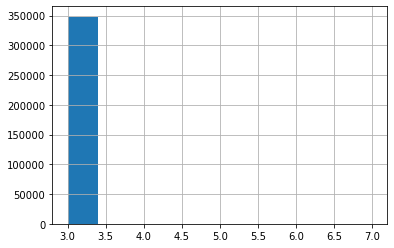

In [64]:
for_predict_df_prod['catBoost_trix_30_100'].hist()

In [65]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'catBoost_trix' and 
            name_feature != 'catBoost_trix_30_100' and 
            name_feature != 'catBoost_prod_152' and
            name_feature != 'catBoost_prod_100'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_catBoost_trix.csv', index=False)
    
save(for_predict_df_prod)

BK
GR
GR_SMA_10
LIT
NKTB
SP
interval_lenght_GRinterval_0.2_
interval_lenght_SPinterval_0.2_
max_GRinterval_0.2_GR
max_SPinterval_0.2_SP
min_GRinterval_0.2_GR
min_SPinterval_0.2_SP
catBoost
